## Random Forest Classifier:

Using a combination of governance characteristics and organizational characteristics (revenue, assets, ect.) I will predict salary using a Random Forest Classifier model.

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import mean_squared_error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from numpy import interp

## IMPORT DATA

In [4]:
# import modeling dataset
features = pd.get_dummies(pd.read_csv('02.data/model_dataset_features_eng.csv'))

y = pd.read_csv('02.data/target_categories.csv', header=None, squeeze=True)

In [5]:
X = features.drop(['reportable_comp'], axis=1)

In [6]:
# verify the size of target and
# feature datasets are the same
X.shape[0] == y.shape[0]

True

## RANDOM FOREST CLASSIFIER
<a id='random_forest'></a>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

In [8]:
rfc = ensemble.RandomForestClassifier(max_depth=20,
                                     n_estimators=500)

In [9]:
# rfc = ensemble.RandomForestClassifier()

# cross_val_score(rfc, X, y, cv=5)

In [10]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
rfc.score(X_train, y_train)

0.7667950079660116

In [12]:
rfc.score(X_test, y_test)

0.24991702071163038

In [13]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(y_test, rfc.predict(X_test)) / \
confusion_matrix(y_test, rfc.predict(X_test)).sum(axis=1, keepdims=True)

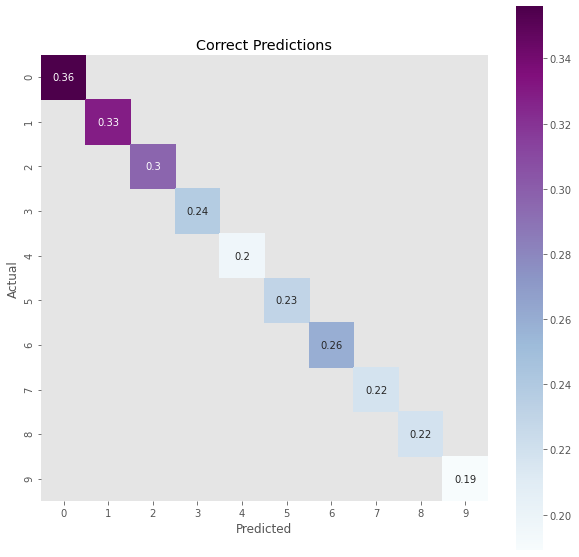

In [14]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(np.where(np.diagflat(np.diagonal(norm_conf_matrix))
            ==0, np.nan, np.diagflat(np.diagonal(norm_conf_matrix))),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Correct Predictions');

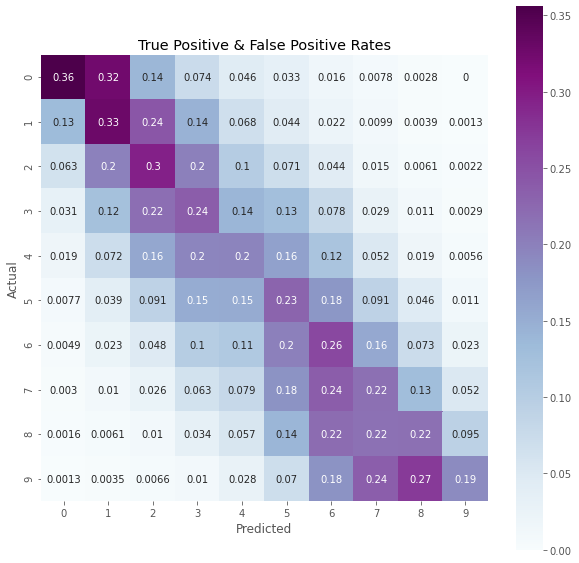

In [15]:
# compare correct and incorrect predictions
plt.figure(figsize=(10, 10))
# np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=True, 
                 cmap='BuPu')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('True Positive & False Positive Rates');

In [16]:
f_importances = pd.Series(rfc.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

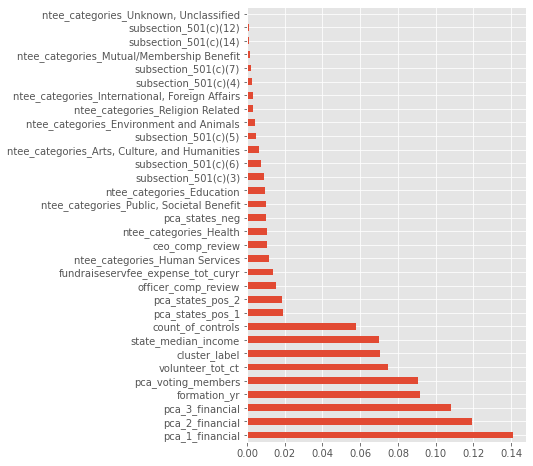

In [17]:
f_importances.plot(kind='barh', figsize=(5, 8));

### Random Forest Classifier 2nd Iteration - selecting only the top features

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X[f_importances[f_importances > .04].index]
                                                    , y, test_size = 0.5)

In [20]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
rfc.score(X_train, y_train)

0.7721720658523632

Training performane increased by reducing features.

In [22]:
rfc.score(X_test, y_test)

0.24492166755177908

However testing performance took a slight hit.

In [1401]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(y_test, rfc.predict(X_test)) / \
confusion_matrix(y_test, rfc.predict(X_test)).sum(axis=1, keepdims=True)

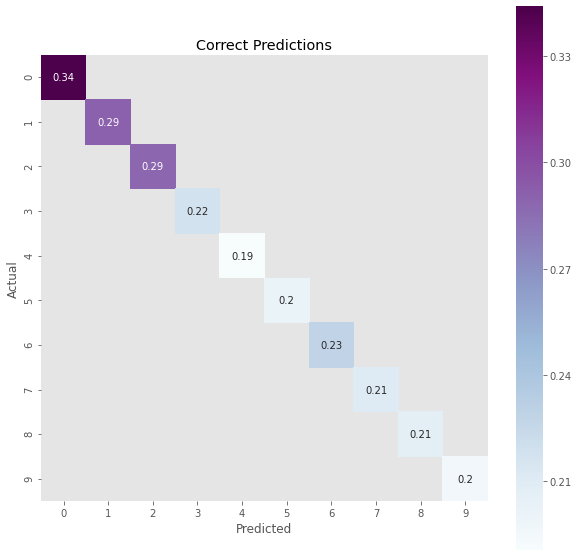

In [1402]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(np.where(np.diagflat(np.diagonal(norm_conf_matrix))
            ==0, np.nan, np.diagflat(np.diagonal(norm_conf_matrix))),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Correct Predictions');

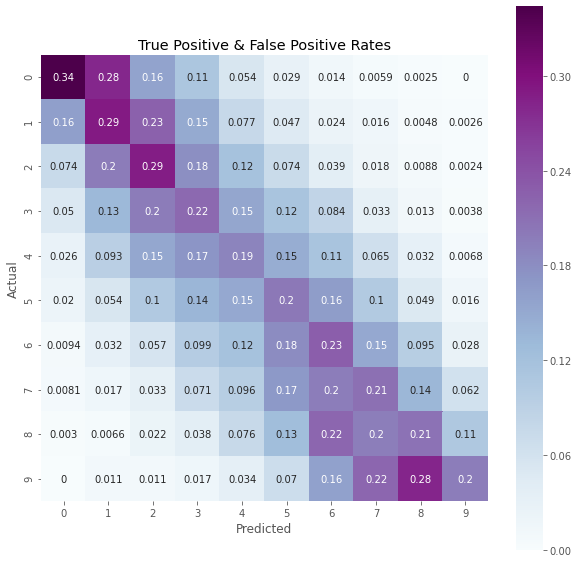

In [1403]:
# compare correct and incorrect predictions
plt.figure(figsize=(10, 10))
# np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=True, 
                 cmap='BuPu')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('True Positive & False Positive Rates');

In [1404]:
f_importances = pd.Series(rfc.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

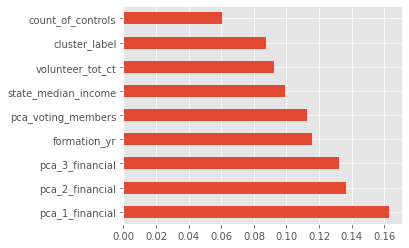

In [1405]:
f_importances.plot(kind='barh', figsize=(5, 4));

### Parameter Tuning

In [1407]:
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'log2'],
#     'max_depth' : [4,10,20,50],
#     'criterion' : ['gini', 'entropy'],
#     'warm_start': [True]
# }

# cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
# cv_rfc.fit(X_train, y_train)

In [ ]:
cv_rfc.best_params_

## Examining classification results 

### Compare composite salaries against actual salaries and compute MSE(mean squared error)

In [41]:
# predict categores
pred = rfc.predict(X_test)

In [42]:
# examine probability of assignment
# to specific categories
prob_pred = pd.DataFrame(rfc.predict_proba(X_test))

In [43]:
# import dict with mean salary for each category
category_mean_salary = pd.read_csv('02.data/category_mean_salary.csv', squeeze=True).to_dict()

In [44]:
# examine dictionary to make sure it looks as it should
category_mean_salary

{0: 60000.0,
 1: 72000.0,
 2: 85079.0,
 3: 101667.5,
 4: 122761.0,
 5: 152129.0,
 6: 187775.0,
 7: 241712.0,
 8: 333669.0,
 9: 537557.5}

In [45]:
# multipy each column probability by 
# the median value for that salary category
frac_salary = pd.DataFrame(prob_pred)

for column in frac_salary.columns:
    frac_salary[column] = frac_salary[column] * category_mean_salary[column]

In [46]:
frac_salary

,0,1,2,3,4,5,6,7,8,9
0,2846.155545,5479.148215,10460.582480,22288.948182,20853.592911,20688.389064,22039.520220,16066.448672,10393.676944,7216.563301
1,15.834376,5994.357105,18904.592085,20698.376683,16719.831293,22557.426174,19683.525300,17090.344039,8718.647234,2448.661589
2,421.599385,28797.791518,1418.981764,3641.498543,5596.278071,61240.868079,7004.871822,7476.407419,6365.743940,2713.930718
3,0.000000,32.099384,148.806071,234.515991,496.768834,36816.342114,47214.052764,114668.351002,5362.679364,4049.059263
4,0.000000,1.086792,10.876569,11249.219748,6558.821887,8387.686039,32957.669316,71331.530479,81465.534531,35408.824246
...,...,...,...,...,...,...,...,...,...,...
60251,6.728972,632.214865,7302.610446,14116.596586,16303.831742,37671.243601,35729.547865,27423.377167,19602.883418,12634.694041
60252,627.320431,1547.246219,1834.158401,20087.312010,17032.189783,56904.978572,10018.925114,10340.364583,42398.208787,6943.028302
60253,915.190476,5765.016871,37698.934109,20460.423677,16634.322877,9983.280552,6531.645597,3970.893072,1596.800932,1720.184000
60254,279.223496,2132.590809,2749.925674,8966.367635,7653.581676,11749.590596,13802.042509,8904.452491,10180.306238,303601.572634


In [47]:
# aggregate total salaries
frac_salary.sum(axis=1)

0        138333.025534
1        132831.595880
2        124677.971258
3        209022.674787
4        247371.249607
             ...      
60251    171423.728704
60252    167733.732203
60253    105276.692162
60254    370019.653757
60255    250897.453944
Length: 60256, dtype: float64

In [48]:
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1)))

178151.2185160979

### Compare category assignment salaries against actual salaries and compute MSE(mean squared error)

In [49]:
category_mean_salary

{0: 60000.0,
 1: 72000.0,
 2: 85079.0,
 3: 101667.5,
 4: 122761.0,
 5: 152129.0,
 6: 187775.0,
 7: 241712.0,
 8: 333669.0,
 9: 537557.5}

In [53]:
# access median salary for each category within dictionary
pd.Series(pred).apply(lambda x: category_mean_salary[x])

0        101667.5
1         85079.0
2        152129.0
3        241712.0
4        241712.0
           ...   
60251    152129.0
60252    152129.0
60253     85079.0
60254    537557.5
60255    152129.0
Length: 60256, dtype: float64

In [54]:
np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_mean_salary[x])))

180100.9406346057

### Accuracy difference between both methods

In [55]:
np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_mean_salary[x]))) - \
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1)))

1949.7221185078088

The difference is actually quite small, nevertheless there is some benefit to computing salaries by prorating each category by percent probability of assignment.

## Confidence Interval
https://kite.com/python/examples/702/scipy-compute-a-confidence-interval-from-a-dataset

do I need to to a box-cox transform before computing the confidence interval?

In [38]:
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95

In [20]:
# list(y_test)

In [29]:
features.reportable_comp

0         198085.0
1          87550.0
2          64575.0
3          62180.0
4         130513.0
            ...   
120507     78600.0
120508    103660.0
120509     92423.0
120510    101450.0
120511     88013.0
Name: reportable_comp, Length: 120512, dtype: float64

In [30]:
features.reportable_comp.shape[0]

120512

In [31]:
features.reportable_comp.mean()

165346.52188163836

In [32]:
features.reportable_comp.sem()

331.78479831067386

In [39]:
n = features.reportable_comp.shape[0]

m = features.reportable_comp.mean()
std_err = features.reportable_comp.sem()
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
print (start)

end = m + h
print (end)

164696.22909504973
165996.814668227


In [40]:
end - start

1300.5855731772608

### Examine precision/recall thresholds
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

Precision = true positive/(true positive + false positive)

Recall = true positive/(true positive + false negative)

In [1290]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=y.unique())
n_classes = Y.shape[1]

In [1239]:
Y.shape

(113851, 10)

In [1291]:
# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

In [1251]:
# Run classifier
classifier = OneVsRestClassifier(rfc)
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)

In [1292]:
rfc.fit(X_train, Y_train)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_score = rfc.predict_proba(X_test)

In [1252]:
pd.DataFrame(y_score).head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.131566,0.000000,0.0,0.117415,0.000000,0.000000,0.000000,0.000000,0.075397,0.64131
1,0.033333,0.000000,0.0,0.000000,0.000000,0.100000,0.060000,0.183333,0.800000,0.00000
2,0.000000,0.000000,0.0,0.000000,0.345000,0.684167,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.481071,0.0,0.000000,0.220635,0.259524,0.000000,0.000000,0.000000,0.00000
4,0.050000,0.000000,0.0,0.000000,0.000000,0.100000,0.027273,0.375000,0.000000,0.20000
5,0.000000,0.000000,0.0,0.800000,0.000000,0.100000,0.041667,0.000000,0.000000,0.10000
6,0.300000,0.000000,0.3,0.350000,0.100000,0.100000,0.100000,0.000000,0.000000,0.00000
7,0.100000,0.171667,0.0,0.300000,0.200000,0.200000,0.180000,0.025000,0.000000,0.00000
8,0.458333,0.000000,0.0,0.300000,0.000000,0.000000,0.000000,0.057143,0.000000,0.00000
9,0.375000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.440000,0.000000,0.00000


In [1260]:
pd.DataFrame(classifier.predict(X_test)).head(20)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


Predict seems to not be making any prediction if the threshold is less than 50%.

In [1253]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.18


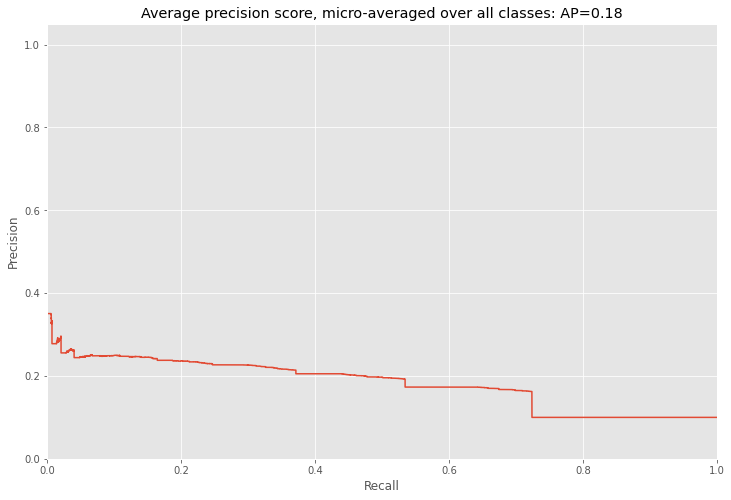

In [1254]:
plt.figure(figsize=(12, 8))
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]));

Clearly, most of the predicted labels are incorrect when compared to the training labels

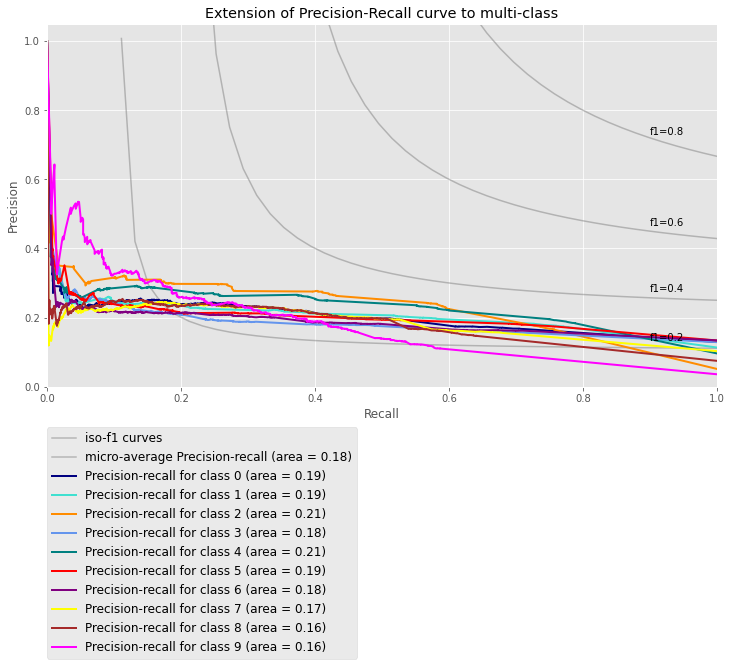

In [1255]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 
                'turquoise', 
                'darkorange', 
                'cornflowerblue', 
                'teal',
                'red',
               'purple',
               'yellow',
               'brown',
               'magenta',
               'green'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.5)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
# l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.75), prop=dict(size=12))

plt.show();

### Examine ROC curve thresholds 

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

True Positive Rate(Recall) = true positive/(true positive + false negative)

False Positive Rate = false positive/(false positive + true positive)

In [1256]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

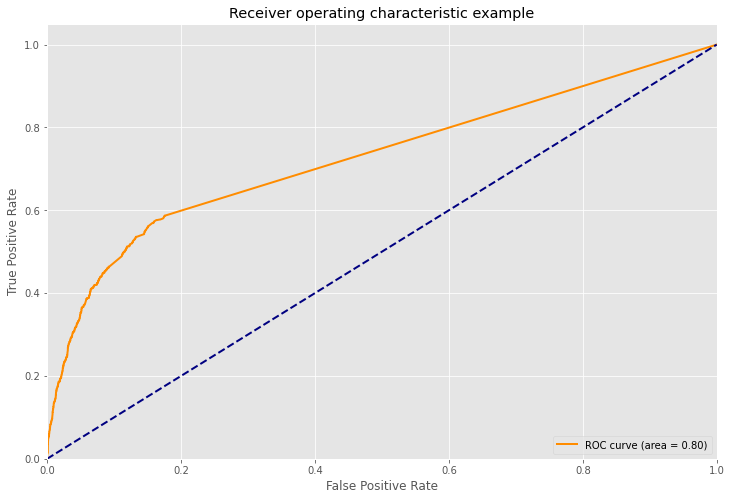

In [1257]:
# plot ROC curve for specific classes
plt.figure(figsize=(12, 8))
lw = 2
plt.plot(fpr[9], tpr[9], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

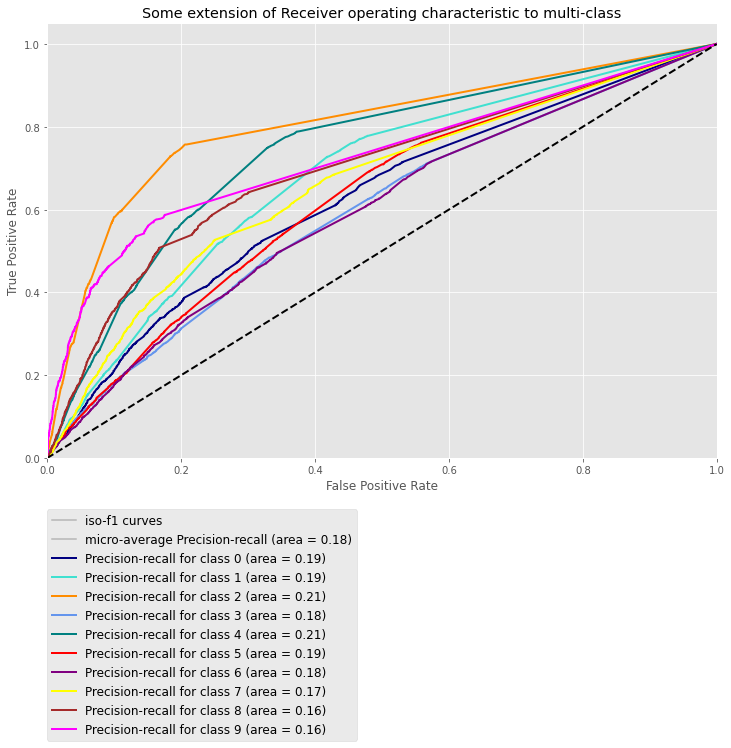

In [1258]:
# plot all classes together
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

plt.figure(figsize=(12, 8))

colors = cycle(['navy', 
                'turquoise', 
                'darkorange', 
                'cornflowerblue', 
                'teal',
                'red',
               'purple',
               'yellow',
               'brown',
               'magenta',
               'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(lines, labels, loc=(0, -.65), prop=dict(size=12))
plt.show()

### Salary Priority Levels
Because my classifier performance isn't great, I could provide a salary average of the top three salary categories.


### Spare parts

In [791]:
# actual_labels.columns = actual_labels.columns.astype(str) + '_'

In [844]:
# per_with_labels = pd.concat([pd.DataFrame(y_score),
#            actual_labels], axis=1)

In [846]:
# https://stackoverflow.com/questions/54923349/top-3-values-per-row-in-pandas

c = ['Level_1','Level_2','Level_3']
salary_priority = (pd.DataFrame(y_score)
        .apply(lambda x: pd.Series(x.nlargest(3).index, index=c), axis=1))

In [850]:
salary_priority

,Level_1,Level_2,Level_3
0,1,3,5
1,7,6,8
2,0,9,7
3,0,9,6
4,5,6,0
...,...,...,...
22766,1,3,5
22767,6,7,8
22768,5,0,1
22769,1,3,5


In [890]:
salary_priority.replace(category_mean_salary)

,Level_1,Level_2,Level_3
0,72767.659661,103119.302046,153813.460139
1,247070.262873,190927.319016,347122.879605
2,59647.825713,589441.843293,247070.262873
3,59647.825713,589441.843293,190927.319016
4,153813.460139,190927.319016,59647.825713
...,...,...,...
22766,72767.659661,103119.302046,153813.460139
22767,190927.319016,247070.262873,347122.879605
22768,153813.460139,59647.825713,72767.659661
22769,72767.659661,103119.302046,153813.460139


In [889]:
salary_priority.replace(category_mean_salary).mean(axis=1)

# , inplace=True

0        109900.140615
1        261706.820498
2        298719.977293
3        280005.662674
4        134796.201623
             ...      
22766    109900.140615
22767    261706.820498
22768     95409.648504
22769    109900.140615
22770    136612.463544
Length: 22771, dtype: float64